# Stock Price Indicator
## I. ETL Pipeline Preparation
### 1. Import libraries and load datasets.
- Import Python libraries
- Load data from Yahoo Finance (Accessing data from the Yahoo finance plattform via the corresponing API you are able to download data since 1950 (if the stock existed))

In [569]:
# import libraries
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline

from alpha_vantage.timeseries import TimeSeries
import os.path


In [553]:
# Download data from Alpha-Vantage

def download_stock_data(symbol, API_key='AG0F6BKQTUPYSY99'):
    try:
        ts = TimeSeries(key = API_key, output_format = 'pandas')
        data = ts.get_daily_adjusted(symbol, outputsize='full') 
        symbol = symbol.upper()
        df = data[0]['5. adjusted close'].reset_index().rename(columns={"5. adjusted close": symbol}).sort_values('date', ascending =True)
        df.to_csv('app/data_wrangling/'+symbol+'.csv', index = False)
        return df
    except Exception as e:
                print('Execption occurred: {}'.format(e))

In [559]:
download_stock_data('NVDA')

,date,NVDA
5426,1999-11-01,1.800125
5425,1999-11-02,1.915027
5424,1999-11-03,2.101933
5423,1999-11-04,2.235985
5422,1999-11-05,2.163980
...,...,...
4,2021-05-20,584.500000
3,2021-05-21,599.670000
2,2021-05-24,624.480000
1,2021-05-25,625.910000


In [573]:
# Import data from csv file

def get_data(symbol='AAPL', start_date='2020-01-01', end_date='2020-12-31'):
    '''
    Setup an empty dataframe with the given timeperiod as index to be used as instance for further gathered data.
    Then loads data from a .csv file for the selected symbol and selects the Adj Close column
    INPUT: 
    symbols - list - symbols of listed stocks
    start_date - datetime - Beginning of the period to analyze
    end_date - datetime - End of the period to analyze
    
    OUTPUT
    df - dataframe - Dataframe containing the Adj Close for the symbol with the time period as index (ordered ascending)
    '''
    try:
        dates= pd.date_range(start_date, end_date)
        df = pd.DataFrame(index=dates)
    
        if os.path.isfile('app/data_wrangling/'+symbol+'.csv') == False:
            print("No such file exists; will be downloaded")
            download_stock_data(symbol)

        df_tmp = pd.read_csv('app/data_wrangling/'+symbol+'.csv', index_col = 'date')
        
        df = df.join(df_tmp)
        df = df.dropna()
    
        return df
    except Exception as e:
                print('Execption occurred: {}'.format(e))

In [578]:
data_analysis_df = get_data(symbol='AAPL', start_date='2020-01-25', end_date='2021-05-25')
data_analysis_df.head()

,AAPL
2020-01-27,76.331554
2020-01-28,78.490926
2020-01-29,80.133926
2020-01-30,80.017804
2020-01-31,76.469912


### 2. Normalize data and plot to check for anomalies

In [579]:
# Noramlize the stock price data

def normalize_stock_data(df):
    df = df/df.iloc[0,:]
    return df

In [580]:
data_analysis_norm = normalize_stock_data(data_analysis_df)

In [581]:
# Plot stock price data and check for anomalies

def plot_stock_data(df):
    if isinstance(df, pd.Series):
        plt.figure(figsize=(12,8))
        ax1 = df.plot()
        ax1.set_xlabel('time')
        ax1.set_ylabel('price')
        ax1.set_title('Stock price development')
        plt.legend(loc='upper right')
        plt.show()
    else:
        plt.figure(figsize=(12,18))
        ax2 = plt.subplot(2,1,1)
        ax2.set_xlabel('time')
        ax2.set_ylabel('price')
        ax2.set_title('Stock price development')
        for col in df.columns:
            df[col].plot()
    
        plt.legend(loc='upper right')

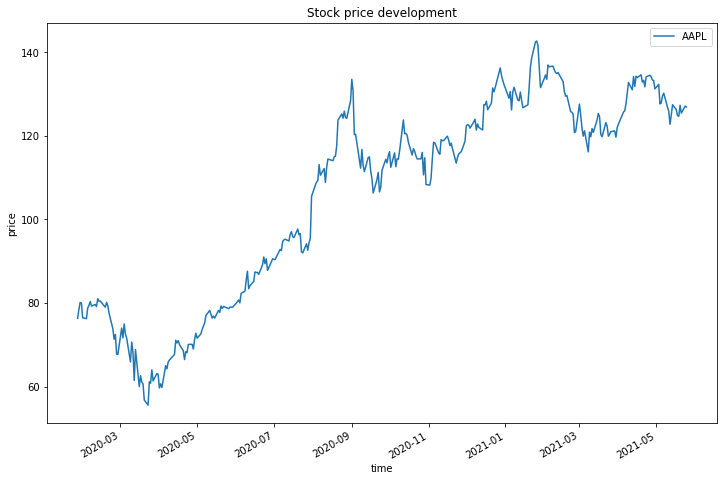

In [582]:
plot_stock_data(data_analysis_df)

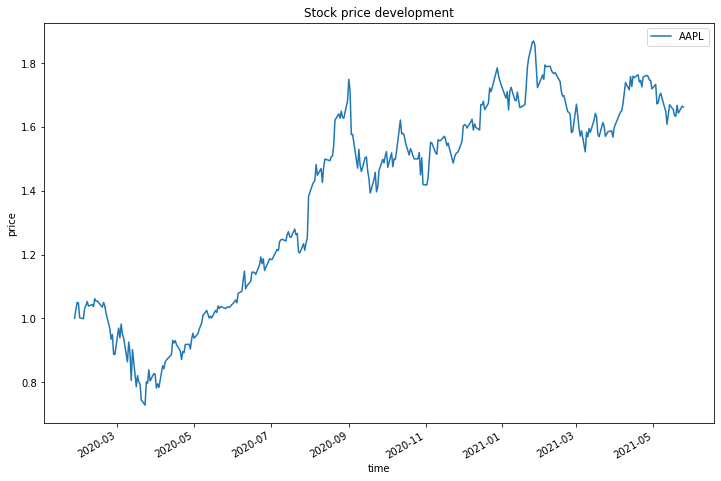

In [583]:
plot_stock_data(data_analysis_norm)

### 3. Feature engineering

In [584]:
# Simple moving average (SMA)

win = 10
sma = data_analysis_norm.rolling(window=win).mean()
std_df = data_analysis_norm.rolling(window=win).std()
sma.tail()
std_df.tail()

,AAPL
2021-05-19,0.029728
2021-05-20,0.026460
2021-05-21,0.018658
2021-05-24,0.018990
2021-05-25,0.019655


In [585]:
# Bollinger(R) Bands

def get_bollinger_bands(rm=sma, rstd=std_df):
    upper_band = rm + rstd*2
    lower_band = rm - rstd*2
    return upper_band, lower_band


In [586]:
b_upper_band, b_lower_band = get_bollinger_bands()
b_upper_band.tail()

,AAPL
2021-05-19,1.714723
2021-05-20,1.705291
2021-05-21,1.683424
2021-05-24,1.684416
2021-05-25,1.687043


In [587]:
# Daily returns

def get_daily_returns(df=data_analysis_df):
    daily_returns = df.copy()
    daily_returns[1:] = (df[1:]/df[:-1].values) - 1
    daily_returns.iloc[0,:] = 0
    return daily_returns

In [588]:
daily_returns = get_daily_returns()
daily_returns.head()

,AAPL
2020-01-27,0.000000
2020-01-28,0.028289
2020-01-29,0.020932
2020-01-30,-0.001449
2020-01-31,-0.044339


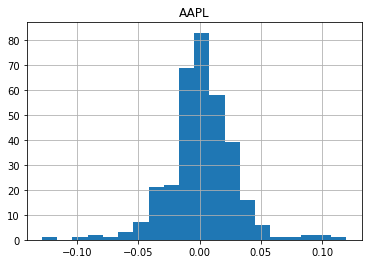

In [589]:
daily_returns.hist(bins= 20)
plt.show()

In [590]:
# Cumulative returns

def get_cumulative_returns(df=data_analysis_df):
    cumulative_returns = df.copy
    cumulative_returns= (df/df.iloc[0]) - 1
    return cumulative_returns

In [591]:
cumulative_returns = get_cumulative_returns()
cumulative_returns.head()

,AAPL
2020-01-27,0.000000
2020-01-28,0.028289
2020-01-29,0.049814
2020-01-30,0.048293
2020-01-31,0.001813


In [592]:
# Momentum

def get_momentum(df=data_analysis_df, win=5):
    df_momentum = df.copy()
    df_momentum[win:] = (df[win:]/df[:-(win)].values) - 1
    df_momentum.iloc[0:(win),:] = 0
    return df_momentum

In [593]:
momentum = get_momentum()
momentum.tail()

,AAPL
2021-05-19,0.015639
2021-05-20,0.018724
2021-05-21,-0.015849
2021-05-24,0.006573
2021-05-25,0.016420


In [594]:
# Get market index

market_index = get_data(symbol='SPY', start_date='2020-01-25', end_date='2021-05-25')
market_index.head(), market_index.tail()


No such file exists; will be downloaded


(                   SPY
 2020-01-27  316.419778
 2020-01-28  319.735583
 2020-01-29  319.471492
 2020-01-30  320.508293
 2020-01-31  314.688516,
                SPY
 2021-05-19  410.86
 2021-05-20  415.28
 2021-05-21  414.94
 2021-05-24  419.17
 2021-05-25  418.24)

### 4. Merge all indicators and symbols into one dataframe

In [595]:
def create_indicator_dataframe(df):
    ''' Function which which takes the Adj Close and corresponding dates per symbol, adds a new column containing the symbol 
        and joins all indicators to one dataframe 
        INPUT: 
        df - dataframe - contains the orginal data to analyse 
        OUTPUT:
        indicator_df - dataframe - contains the Adj Close and all indicators as features tagged by the symbol '''
    indicator_df = pd.DataFrame(columns=['Date','Symbol', 'Adj Close','Daily Returns','Cumulative Returns','SMA', 'Momentum', 'Upper Band','Lower Band','Market Index'])
    
    for symbol in df.columns:
        df_temp = df[symbol].reset_index().rename(columns={'index':'Date', symbol:'Adj Close'})
        df_temp['Symbol']= symbol

        df_temp = df_temp.join(daily_returns[symbol], on='Date').rename(columns={symbol:'Daily Returns'})
        df_temp = df_temp.join(cumulative_returns[symbol], on='Date').rename(columns={symbol:'Cumulative Returns'})
        df_temp = df_temp.join(sma[symbol], on='Date').rename(columns={symbol:'SMA'})
        df_temp = df_temp.join(momentum[symbol], on='Date').rename(columns={symbol:'Momentum'})
        df_temp = df_temp.join(b_upper_band[symbol], on='Date').rename(columns={symbol:'Upper Band'})
        df_temp = df_temp.join(b_lower_band[symbol], on='Date').rename(columns={symbol:'Lower Band'})
        df_temp = df_temp.join(market_index['SPY'], on='Date').rename(columns={'SPY':'Market Index'})
        indicator_df = pd.concat([indicator_df, df_temp])
        
        indicator_df.fillna(method='ffill', inplace=True)
        indicator_df.fillna(method='bfill', inplace=True)
        indicator_df.dropna()
    
    return indicator_df

In [596]:
indicator_model_df = create_indicator_dataframe(data_analysis_df)
indicator_model_df

,Date,Symbol,Adj Close,Daily Returns,Cumulative Returns,SMA,Momentum,Upper Band,Lower Band,Market Index
0,2020-01-27,AAPL,76.331554,0.000000,0.000000,1.029076,0.000000,1.071601,0.986551,316.419778
1,2020-01-28,AAPL,78.490926,0.028289,0.028289,1.029076,0.000000,1.071601,0.986551,319.735583
2,2020-01-29,AAPL,80.133926,0.020932,0.049814,1.029076,0.000000,1.071601,0.986551,319.471492
3,2020-01-30,AAPL,80.017804,-0.001449,0.048293,1.029076,0.000000,1.071601,0.986551,320.508293
4,2020-01-31,AAPL,76.469912,-0.044339,0.001813,1.029076,0.000000,1.071601,0.986551,314.688516
...,...,...,...,...,...,...,...,...,...,...
331,2021-05-19,AAPL,124.690000,-0.001282,0.633532,1.655267,0.015639,1.714723,1.595812,410.860000
332,2021-05-20,AAPL,127.310000,0.021012,0.667855,1.652370,0.018724,1.705291,1.599450,415.280000
333,2021-05-21,AAPL,125.430000,-0.014767,0.643226,1.646108,-0.015849,1.683424,1.608793,414.940000
334,2021-05-24,AAPL,127.100000,0.013314,0.665104,1.646436,0.006573,1.684416,1.608455,419.170000


## II. MACHINE LEARNING PIPELINE 

### 1. Create train and test data and standardize

In [597]:
from sklearn import preprocessing

def create_train_test_data(indicator_df, symbol, train_size=0.8, start_pred='2021-05-07', end_pred='2021-05-14'):
    ''' Splits the indicator dataframe into a train and test dataset and standardizes the data of the indipendent variable
        INPUT:
        indicator_df - dataframe object - dataframe which contains the Adj Close and different indicators for each symbol
        symbol - str - symbol of the listed company for which you want to predict stock price
        train_size - float - size of train dataset
        start_pred - str - start date of prediction
        end_pred - str - end date of prediction
        OUTPUT:
        pred_days - int - days to be predicted
        Y_train - 1d array - contains the training dataset of the dependent variable (stock price)
        Y_test - 1d array - contains the test dataset of the dependent variable (stock price)
        X_train - nd array - contains the training dataset of the independent variables
        X_test - nd array - contains the test dataset of the independent variables
        X_predict = nd array - contains the data of the independent variable for the prediction period
        time_series_train - 1d array - selected time period of training data
        time_series_test - 1d array - selected time period of test data
    '''
    sd = dt.datetime.strptime(start_pred, '%Y-%m-%d')
    ed = dt.datetime.strptime(end_pred, '%Y-%m-%d')
    
    try:
        if sd >= ed:
            raise ValueError('Start date beyound end date')
        else:
            pred_days = (ed-sd).days

            indicator_df = indicator_df[indicator_df['Date'] <= start_pred] 
            
            df = indicator_df.copy().drop(['Symbol','Date'], axis=1)
            
            for i in range(1,pred_days):
                indicator_df=indicator_df.join(df.shift(i), rsuffix="[{} day before]".format(i))

        
            train_df = indicator_df.copy().iloc[pred_days:] # Training data starts from the date where data for all indicators is available
            
            if pred_days > 0:
                X = train_df.iloc[:-pred_days,3:] # Reduces the X Date by the number of pred_days at the end of the dataframe
                X_predict = train_df.iloc[-pred_days:, 3:]
                Y = train_df.drop('Symbol', axis=1).iloc[pred_days:,:2] # Starts at pred_days and takes all data until the end of the dataframe
                
                X.fillna(method='ffill', inplace=True)
                X.fillna(method='bfill', inplace=True)

                Y.fillna(method='ffill', inplace=True)
                Y.fillna(method='bfill', inplace=True)
                
            
            train_ct = int(X.shape[0] * train_size)
            test_ct = X.shape[0] - train_size

            X_train, X_test = X.iloc[:train_ct], X.iloc[train_ct:]  
            Y_train, Y_test = Y.iloc[:train_ct].copy().drop('Date', axis=1), Y.iloc[train_ct:].copy().drop('Date', axis=1)

            time_series_train = Y.iloc[:train_ct].Date
            time_series_test = Y.iloc[train_ct:].Date   


            return pred_days, preprocessing.scale(X_train), Y_train['Adj Close'].tolist(), preprocessing.scale(X_test), Y_test['Adj Close'].tolist(), time_series_train, time_series_test, preprocessing.scale(X_predict)
        
    
    except ValueError:
        raise
        

In [598]:
pred_days, X_train, Y_train, X_test, Y_test, time_series_train, time_series_test, X_predict   = create_train_test_data(indicator_model_df, symbol='AAPL', train_size=0.8)

In [599]:
pred_days, len(X_train), len(Y_train),  len(time_series_train)

(7, 248, 248, 248)

In [600]:
len(X_test), len(Y_test),len(time_series_test)

(62, 62, 62)

### 2. Setup and validate different models

In [601]:
from sklearn import linear_model

from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score


In [602]:
# Evaluate model performance and plot data
def evaluate_model_performance(Y_test, Y_predict, Y_future, time_series_test):
    ''' Function that generates different performance indicators comparing test data and the predicted data
        and plots the data
        INPUT:
        Y_test - 1d array - contains the test dataset of the dependent variable (stock price)
        Y_predict - 1d array - contains the predicted dataset of the dependent variable (stock price) for the test period
        Y_future - 1d array - contains the predicted dataset of the dependent variable (stock price) for a future period
        time_series_test - 1d array - selected time period of test data
    '''
    
    corr = np.corrcoef(Y_test, Y_predict)
    corrcoef = corr[0,1]
    mae = mean_absolute_error(Y_test, Y_predict)
    mape = mean_absolute_percentage_error(Y_test, Y_predict)
    r2 = r2_score(Y_test, Y_predict)
    
    fig = plt.figure(figsize=(12,8))
    
    value_days = len(Y_future)
    end_date = (time_series_test.iloc[-1] + dt.timedelta(days=value_days+1))

    time_series_future = pd.date_range(time_series_test.iloc[-1]+ dt.timedelta(days=2) , end_date).tolist()

    plt.plot(time_series_test, Y_test, color='lightblue', linewidth=2, label='test data')
    plt.plot(time_series_test, Y_predict.reshape(-1,1), color='red',  linewidth=2, label='predicted data')
    
    plt.plot(time_series_future , Y_future.reshape(-1,1), color='green',  linewidth=2, label='future predicted data')
    
    plt.legend()
    
    return print(('MAE {} \n MAPE {} \n r2 {} \n CORRCOEF {} \n').format(mae, mape, r2 , corrcoef))

In [603]:
# Lasso LARS

lassolars = linear_model.LassoLars(alpha = 0.1)
lassolars.fit(X_train, Y_train)
Y_lassolars_predict = lassolars.predict(X_test)
Y_lassolars_future = lassolars.predict(X_predict)

MAE 27.122201893255685 
 MAPE 0.21509600608680726 
 r2 -33.286003267616024 
 CORRCOEF 0.4798883476895699 



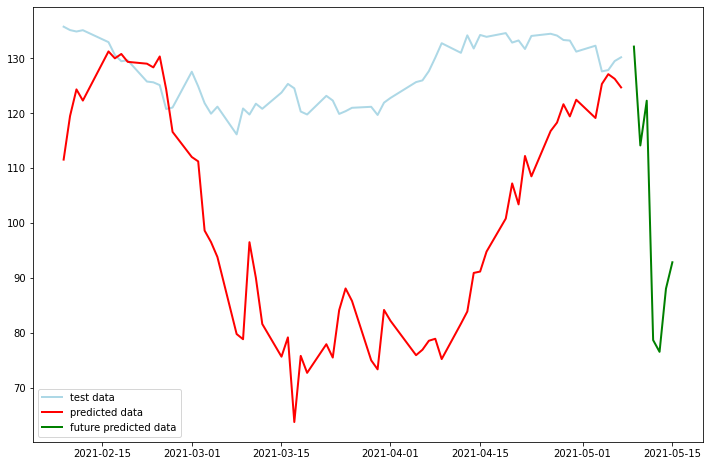

In [604]:
evaluate_model_performance(Y_test, Y_lassolars_predict, Y_lassolars_future, time_series_test)

In [605]:
Y_lassolars_future

array([132.15698351, 114.14819285, 122.29636206,  78.68664578,
        76.54857828,  88.04691761,  92.86631568])

In [606]:
# knn
knn = KNeighborsRegressor(n_neighbors=15)  #weights='distance'
knn.fit(X_train, Y_train)
Y_knn_predict = knn.predict(X_test)
Y_knn_future = knn.predict(X_predict)

MAE 26.53840266516645 
 MAPE 0.2080248745118207 
 r2 -32.518518472932975 
 CORRCOEF 0.16434800559579846 



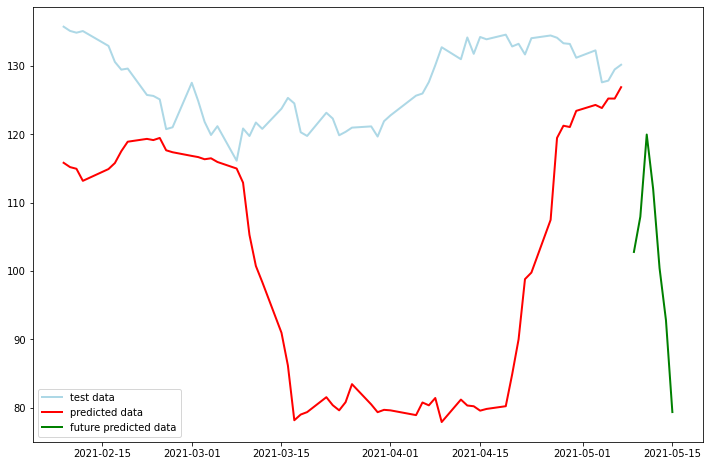

In [607]:
evaluate_model_performance(Y_test, Y_knn_predict, Y_knn_future, time_series_test)

In [608]:
# AdaBoost
AdaBoost = AdaBoostRegressor(base_estimator=knn, random_state=42)
AdaBoost.fit(X_train, Y_train)
Y_AdaBoost_predict = AdaBoost.predict(X_test)
Y_AdaBoost_future = AdaBoost.predict(X_predict)

MAE 28.4189736623972 
 MAPE 0.22301708790868427 
 r2 -37.36263410889944 
 CORRCOEF 0.18162182763693696 



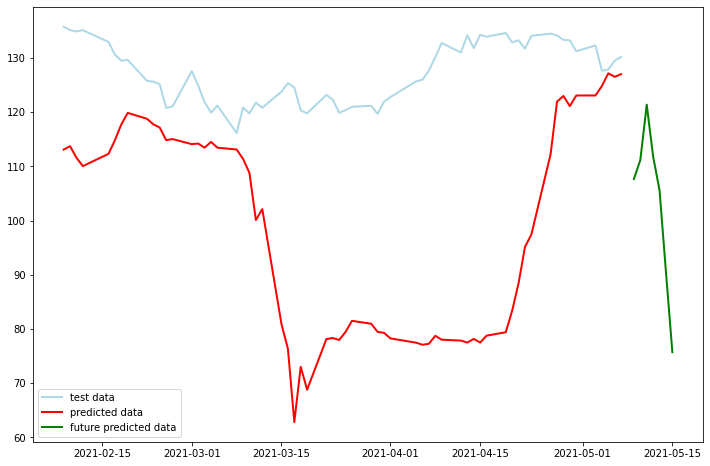

In [609]:
evaluate_model_performance(Y_test, Y_AdaBoost_predict, Y_AdaBoost_future, time_series_test)

In [611]:
# Random Forest Regression
randomforest = RandomForestRegressor(random_state=42, criterion='mse', n_estimators=10, min_samples_split=10)
randomforest.fit(X_train, Y_train)
Y_randomforest_predict = randomforest.predict(X_test)
Y_randomforest_future = randomforest.predict(X_predict)

MAE 27.24852644691558 
 MAPE 0.2132767448582601 
 r2 -34.494504174453176 
 CORRCOEF 0.11807999964097582 



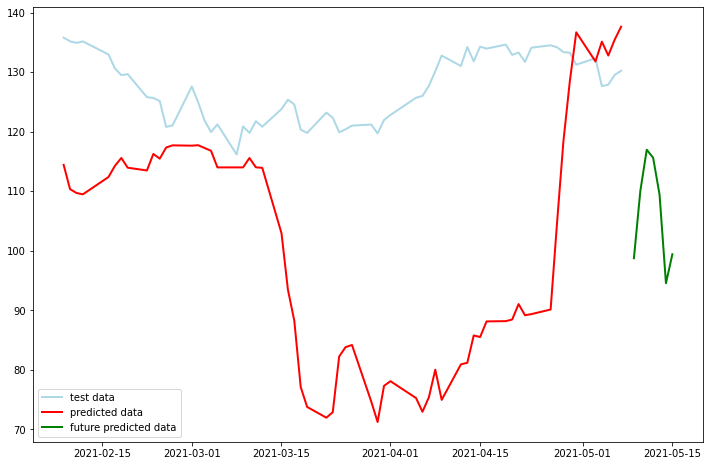

In [612]:
evaluate_model_performance(Y_test, Y_randomforest_predict, Y_randomforest_future, time_series_test)

### 3. Put all the above into one class

In [613]:
class StockDataAnalysis():
    ''' Creates a StockDataAnalysis object which is able to take one or mutiple stock symbols and a timeframe and then computes
        a range of indicators on the stock data and plots the results'''
    
    def __init__(self, symbol='AAPL', start_date='2020-01-01', end_date='2021-04-16'):
        ''' Create an instance of StockDataAnalysis'''
        self.symbol = symbol
        self.start_date = start_date
        self.end_date = end_date
        
        self.data = get_data(self.symbol, self.start_date, self.end_date)
        self.data_norm = normalize_stock_data(self.data)
        
    # Plot stock price data and check for anomalies

    def plot_stock_data(self, normalized=True):
        if normalized:
            df = self.data_norm
            title_str = 'Relative stock price development'
        else:
            df = self.data
            title_str = 'Absolute stock price development'
        if isinstance(df, pd.Series):
            plt.figure(figsize=(12,8))
            ax1 = df.plot()
            ax1.set_xlabel('time')
            ax1.set_ylabel('price')
            ax1.set_title(title_str)
            plt.legend(loc='upper right')
            plt.show()
        else:
            plt.figure(figsize=(12,18))
            ax2 = plt.subplot(2,1,1)
            ax2.set_xlabel('time')
            ax2.set_ylabel('price development')
            ax2.set_title(title_str)
            for col in df.columns:
                df[col].plot()
        
            plt.legend(loc='upper right')
           
    def calculate_rolling_stats(self, win=10):
        rm = self.data_norm.rolling(window=win).mean()
        rstd = self.data_norm.rolling(window=win).std()
        self.sma = rm.dropna()
        self.rstd = rstd.dropna()
        
    def calculate_bollinger_bands(self):
        self.b_upper_band = self.sma + self.rstd*2
        self.b_lower_band = self.sma - self.rstd*2
            
    def calculate_daily_returns(self):
        daily_returns = self.data.copy()
        daily_returns[1:] = (self.data[1:]/self.data[:-1].values) - 1
        daily_returns.iloc[0,:] = 0
        self.daily_returns = daily_returns
        

    def calculate_cumulative_returns(self):
        cumulative_returns = self.data.copy
        cumulative_returns= (self.data/self.data.iloc[0]) - 1
        self.cumulative_returns = cumulative_returns
        
        
    def calculate_momentum(self, win=5):
        self.momentum = self.data.copy()
        self.momentum[win:] = (self.data[win:]/self.data[:-(win)].values) - 1
        self.momentum.iloc[0:(win),:] = 0
        
    
    def get_market_index(self, market_ix='SPY'):
        self.market_ix = market_ix
        self.market_index = get_data(symbol=market_ix, start_date=self.start_date, end_date=self.end_date)
        
    def setup_features(self, market_ix='SPY'):
        self.calculate_rolling_stats()
        self.calculate_bollinger_bands()
        self.calculate_daily_returns()
        self.calculate_cumulative_returns()
        self.calculate_momentum()
        self.get_market_index(market_ix=market_ix)
        
            
    def create_indicator_dataframe(self):
        ''' Function which which takes the Adj Close and corresponding dates per symbol, adds a new column containing the symbol 
            and joins all indicators to one dataframe 
            INPUT: 
            object 
            OUTPUT:
            indicator_df - dataframe - contains the Adj Close and all indicators as features tagged by the symbol '''
        
        self.indicator_df = pd.DataFrame(columns=['Date','Symbol', 'Adj Close','Daily Returns','Cumulative Returns','SMA', 'Momentum', 'Upper Band','Lower Band','Market Index'])
        
        for symbol in self.data.columns:
            df_temp = self.data[symbol].reset_index().rename(columns={'index':'Date', symbol:'Adj Close'})
            df_temp['Symbol'] = symbol
            
            df_temp = df_temp.join(self.daily_returns[symbol], on='Date').rename(columns={symbol:'Daily Returns'})
            df_temp = df_temp.join(self.cumulative_returns[symbol], on='Date').rename(columns={symbol:'Cumulative Returns'})
            df_temp = df_temp.join(self.sma[symbol], on='Date').rename(columns={symbol:'SMA'})
            df_temp = df_temp.join(self.momentum[symbol], on='Date').rename(columns={symbol:'Momentum'})
            df_temp = df_temp.join(self.b_upper_band[symbol], on='Date').rename(columns={symbol:'Upper Band'})
            df_temp = df_temp.join(self.b_lower_band[symbol], on='Date').rename(columns={symbol:'Lower Band'})
            df_temp = df_temp.join(self.market_index[self.market_ix], on='Date').rename(columns={self.market_ix:'Market Index'})                   

            self.indicator_df = pd.concat([self.indicator_df, df_temp])
            
            self.indicator_df.fillna(method='ffill', inplace=True)
            self.indicator_df.fillna(method='bfill', inplace=True)
            self.indicator_df.dropna()

        return self.indicator_df

In [614]:
st_data = StockDataAnalysis('AAPL','2020-12-25','2021-05-21')

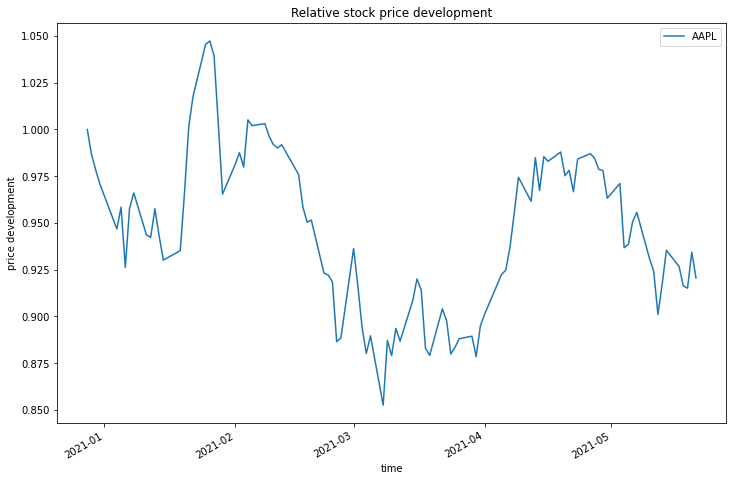

In [615]:
st_data.plot_stock_data()

In [616]:
st_data.setup_features()

In [617]:
st_data.calculate_rolling_stats()

In [618]:
st_data.calculate_bollinger_bands()

In [619]:
st_data.calculate_daily_returns()

In [620]:
st_data.calculate_momentum()

In [621]:
st_data.calculate_cumulative_returns()

In [622]:
st_data.get_market_index()

In [623]:
st_data.create_indicator_dataframe()
st_data.indicator_df

,Date,Symbol,Adj Close,Daily Returns,Cumulative Returns,SMA,Momentum,Upper Band,Lower Band,Market Index
0,2020-12-28,AAPL,136.255198,0.000000,0.000000,0.963450,0.000000,1.007037,0.919863,370.952995
1,2020-12-29,AAPL,134.440987,-0.013315,-0.013315,0.963450,0.000000,1.007037,0.919863,370.245316
2,2020-12-30,AAPL,133.294645,-0.008527,-0.021728,0.963450,0.000000,1.007037,0.919863,370.773583
3,2020-12-31,AAPL,132.267922,-0.007703,-0.029263,0.963450,0.000000,1.007037,0.919863,372.657403
4,2021-01-04,AAPL,128.998355,-0.024719,-0.053259,0.963450,0.000000,1.007037,0.919863,367.584047
...,...,...,...,...,...,...,...,...,...,...
96,2021-05-17,AAPL,126.270000,-0.009259,-0.073283,0.931685,-0.004572,0.963309,0.900061,415.520000
97,2021-05-18,AAPL,124.850000,-0.011246,-0.083705,0.929642,-0.008419,0.962436,0.896847,411.940000
98,2021-05-19,AAPL,124.690000,-0.001282,-0.084879,0.927298,0.015639,0.960605,0.893990,410.860000
99,2021-05-20,AAPL,127.310000,0.021012,-0.065650,0.925675,0.018724,0.955321,0.896028,415.280000


In [624]:
class ModelStockPrice():
    def __init__(self, start_predict=None, end_predict=None):
        '''Create an instance of the model to predict stockprice'''
        
        self.start_predict = start_predict
        self.end_predict = end_predict
        
        self.model = linear_model.LassoLars(alpha = 0.1)


    def create_train_test_data(self, stockdata, train_size=0.8, start_pred='2019-05-10', end_pred='2019-05-17'):
        ''' Splits the indicator dataframe into a train and test dataset and standardizes the data of the indipendent variable
            INPUT:
            indicator_df - dataframe object - dataframe which contains the Adj Close and different indicators for each symbol
            symbol - str - symbol of the listed company for which you want to predict stock price
            train_size - float - size of train dataset
            start_pred - str - start date of prediction
            end_pred - str - end date of prediction
            OUTPUT:
            pred_days - int - days to be predicted
            Y_train - 1d array - contains the training dataset of the dependent variable (stock price)
            Y_test - 1d array - contains the test dataset of the dependent variable (stock price)
            X_train - nd array - contains the training dataset of the independent variables
            X_test - nd array - contains the test dataset of the independent variables
            X_predict = nd array - contains the data of the independent variable for the prediction period
            time_series_train - 1d array - selected time period of training data
            time_series_test - 1d array - selected time period of test data
            time_series_test - 1d array - predicted time period

        '''
        sd = dt.datetime.strptime(start_pred, '%Y-%m-%d')
        ed = dt.datetime.strptime(end_pred, '%Y-%m-%d')

        try:
            if sd >= ed:
                raise ValueError('Start date beyound end date')
            else:
                self.pred_days = (ed-sd).days

                indicator_df = stockdata.indicator_df[stockdata.indicator_df['Date'] <= start_pred] 

                df = stockdata.indicator_df.copy().drop(['Symbol','Date'], axis=1)

                for i in range(1, self.pred_days):
                    indicator_df=indicator_df.join(df.shift(i), rsuffix="[{} day before]".format(i))


                train_df = indicator_df.copy().iloc[self.pred_days:] # Training data starts from the date where data for all indicators is available

                if self.pred_days > 0:
                    X = train_df.iloc[:-pred_days,3:] # Reduces the X Date by the number of pred_days at the end of the dataframe
                    self.X_predict = preprocessing.scale(train_df.iloc[-pred_days:, 3:])
                    Y = train_df.drop('Symbol', axis=1).iloc[pred_days:,:2] # Starts at pred_days and takes all data until the end of the dataframe

                    X.fillna(method='ffill', inplace=True)
                    X.fillna(method='bfill', inplace=True)

                    Y.fillna(method='ffill', inplace=True)
                    Y.fillna(method='bfill', inplace=True)


                train_ct = int(X.shape[0] * train_size)
                test_ct = X.shape[0] - train_size

                self.X_train, self.X_test = preprocessing.scale(X.iloc[:train_ct]), preprocessing.scale(X.iloc[train_ct:])  
                self.Y_train, self.Y_test = Y.iloc[:train_ct]['Adj Close'].copy().tolist(), Y.iloc[train_ct:]['Adj Close'].copy().tolist()

                self.time_series_train = Y.iloc[:train_ct].Date
                self.time_series_test = Y.iloc[train_ct:].Date   


                return self.pred_days, self.X_train, self.Y_train, self.X_test, self.Y_test, self.time_series_train, self.time_series_test, X_predict


        except ValueError:
            raise

            
    def fit(self):
        '''Fit the model with training data '''
        self.model.fit(self.X_train, self.Y_train)

    def predict(self):
        '''Predict stockprice '''
        self.Y_predict = self.model.predict(self.X_test)
        self.Y_future = self.model.predict(self.X_predict)
        return self.Y_predict, self.Y_future
    
    def evaluate_model_performance(self):
        ''' Function that generates different performance indicators comparing test data and the predicted data
            and plots the data
            INPUT:
            Y_test - 1d array - contains the test dataset of the dependent variable (stock price)
            Y_predict - 1d array - contains the predicted dataset of the dependent variable (stock price) for the test period
            Y_future - 1d array - contains the predicted dataset of the dependent variable (stock price) for a future period
            time_series_test - 1d array - selected time period of test data
        '''

        corr = np.corrcoef(self.Y_test, self.Y_predict)
        corrcoef = corr[0,1]
        mae = mean_absolute_error(self.Y_test, self.Y_predict)
        mape = mean_absolute_percentage_error(self.Y_test, self.Y_predict)
        r2 = r2_score(self.Y_test, self.Y_predict)

        fig = plt.figure(figsize=(12,8))

        value_days = len(self.Y_future)
        end_date = (self.time_series_test.iloc[-1] + dt.timedelta(days=value_days+1))

        time_series_future = pd.date_range(self.time_series_test.iloc[-1]+ dt.timedelta(days=2) , end_date).tolist()

        plt.plot(self.time_series_test, self.Y_test, color='lightblue', linewidth=2, label='test data')
        plt.plot(self.time_series_test, self.Y_predict.reshape(-1,1), color='red',  linewidth=2, label='predicted data')

        plt.plot(time_series_future , self.Y_future.reshape(-1,1), color='green',  linewidth=2, label='future predicted data')

        plt.legend()

        return print(('MAE {} \n MAPE {} \n r2 {} \n CORRCOEF {} \n').format(mae, mape, r2 , corrcoef))
    

In [625]:
price_reg = ModelStockPrice()

In [626]:
price_reg.create_train_test_data(st_data, start_pred='2021-05-25', end_pred='2021-05-30')

(5,
 array([[ 0.57925357,  0.35136835,  0.53902411, ...,  0.38499178,
          0.59222347, -1.57475785],
        [-1.71243762, -0.33936857,  0.53902411, ...,  0.38499178,
          0.59222347, -1.52278072],
        [ 1.6626969 ,  0.33727168,  0.53902411, ...,  0.38499178,
          0.59222347, -1.33742829],
        ...,
        [-0.9253072 ,  0.54212918,  0.01606983, ..., -0.57245631,
         -1.10871951,  2.19115764],
        [ 0.89513676,  0.92958442,  0.24068238, ..., -0.1536748 ,
         -1.18340271,  2.48338133],
        [-0.16223215,  0.8762505 ,  0.44365211, ...,  0.03896383,
         -1.04915145,  2.4981401 ]]),
 [128.49994545299998,
  126.73557571100001,
  127.423380865,
  131.610020931,
  136.434625197,
  138.62762713700002,
  142.465380531,
  142.704617106,
  141.608116136,
  136.653925391,
  131.540243597,
  133.713309155,
  134.560605358,
  133.513945342,
  136.95297111,
  136.529323009,
  136.679069999,
  135.780588055,
  135.161633827,
  134.902072376,
  135.141667561

In [627]:
price_reg.fit()

In [628]:
Y_predict, Y_future_predict = price_reg.predict()
Y_future_predict

array([126.22138179, 131.35280113, 128.93108546, 126.45765523,
       126.52553956, 132.68733788, 129.1713961 ])

MAE 2.2947300738275027 
 MAPE 0.01809362380103057 
 r2 0.13650067169396007 
 CORRCOEF 0.5885341216392308 



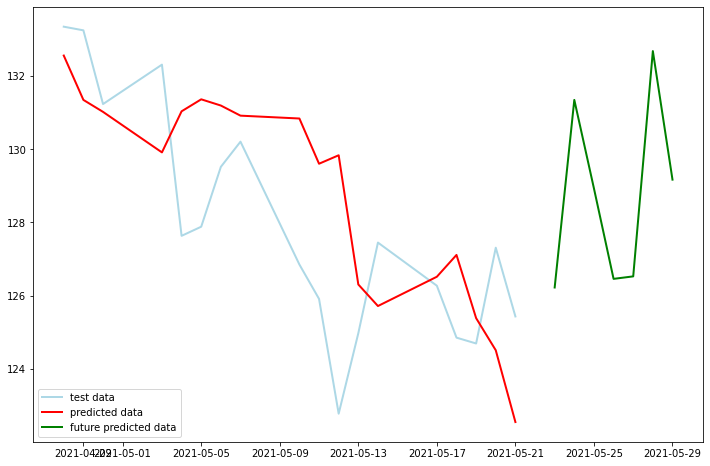

In [629]:
price_reg.evaluate_model_performance()